# CPP Analysis 
Author: Joseph Lee

Import necessary packages and functions

In [1]:
import os
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pathlib import Path
from scipy.ndimage import gaussian_filter1d

In [5]:
# Input CSV filepath

fps = 5  # Replace with your actual FPS
directory = "/Users/josephlee/Desktop/Filtered Data/Ying DLC Output"
CPP_Analysis_Output = analyze_tracking_data(directory)
CPP_Analysis_Output.to_csv('DLC_Annelies012425_10min.csv', index=False)

In [2]:
def analyze_tracking_data(directory):
    place_preferences = []
    combined_locomotion_data = []
    for filename in sorted(os.listdir(directory), key=lambda x: x.lower()):
        if filename.endswith('.csv'):
            
            filepath = os.path.join(directory, filename)
            
            #Defining columns
            columns= ['frame', 'head_x', 'head_y', 'head_likelihood', 'body_x','body_y','body_likelihood',
                      'left_top_x', 'left_top_y', 'left_top_likelihood',
                      'left_bottom_x', 'left_bottom_y', 'left_bottom_likelihood',
                      'border_top_x','border_top_y','border_top_likelihood', 'border_bottom_x','border_bottom_y','border_bottom_likelihood', 'right_top_x','right_top_y','right_top_likelihood', 'right_bottom_x','right_bottom_y','right_bottom_likelihood']
            
            df = pd.read_csv(filepath, skiprows=3, names=columns, encoding='utf-8')  # Replace with your specific CSV reading logic
            
            #Getting rid of unwanted columns
            df = df.drop(columns=['frame','head_x','head_y','head_likelihood','left_bottom_x', 'left_bottom_y','left_bottom_likelihood', 'right_bottom_x','right_bottom_y','right_bottom_likelihood', 'right_top_x','right_top_y','right_top_likelihood'])
            
            df = df.head(3176) # 10 min
            #df = df.head(3840) # 4 min
            
            # Calculate Place Preference
            place_preference = calculate_place_preference(df)
            
            # Calculate Locomotion
            locomotion = calculate_locomotion(df)
                    
            # Organizing analysis results into the data frame
            place_preference = {'filename': filename, **place_preference, 'locomotion': locomotion['total_displacement']}

            # Appending place preference to master list 
            place_preferences.append(place_preference)
        

    # Creating a data frame from the master list containing appended place preference data
    preferences_df = pd.DataFrame(place_preferences)
  

    return preferences_df

In [3]:
'''
# Creating a place preference function

In essence, this function will take the markers for the top and bottom x and y values of the border (border between the distinct left and right chamber in the place preference apparatus) and compare the x value of the body of the mouse at every given frame to sort frames whether the mouse was on the left or right side of the chamber. Then using the known FPS of the video, the time in the left or right side of the chamber will be calculated, revealing place preference
'''

def calculate_place_preference(df):

    # Defining the midline in which the left and right chamber will be separated
    border_top_x = df['border_top_x'].mean()
    border_bottom_x = df['border_bottom_x'].mean()
    midline_x_estimate = (border_top_x + border_bottom_x) / 2

    # Sorting the left and right frames based on whether the x value of the mouse's body is greater or less than the border x value
    right_frames = df[df['body_x'] > midline_x_estimate]
    left_frames = df[df['body_x'] < midline_x_estimate]
    
    # Number of frames taken from number of rows in the csv
    num_frames = len(df) 

    num_right_frames = len(right_frames) #number of right frames
    num_left_frames = len(left_frames) #number of left frames

    # Calculating the proportion of time spent in the left or right side of the chamber 
    proportion_right_frames = round((num_right_frames / num_frames) * 100, 4)
    proportion_left_frames = round((num_left_frames / num_frames) * 100, 4)

    # Calculating the time spent in the left or right side of the chamber based on fps
    time_in_right = round(num_right_frames / fps, 5)
    time_in_left = round(num_left_frames / fps, 2)

    #Creating a dictionary to store appropriate analysis data 
    place_preference = {
        'proportion_right': proportion_right_frames,
        'proportion_left': proportion_left_frames,
        'time_on_right': time_in_right,
        'time_on_left': time_in_left,       
    }

    return place_preference 


In [4]:
"""
#Locomotion Analysis
Creating a function for calculating the locomotion of the subject mouse during the experiment test
"""

def calculate_locomotion(df):

    '''
    This function calculates locomotion by first defining the coordinates of the mouse's x and y value in an array, and then recording the change in distance between each corresponding point in the array. The changes in pixel distance will then be converted to cm using a real-life reference of the length of the chamber.
    '''
    #Calculating difference between consecutive x and y cooridinates of the body position
    body_displacement_x = np.diff(df['body_x'])
    body_displacement_y = np.diff(df['body_y'])
    body_displacement = np.sqrt(body_displacement_x**2 + body_displacement_y**2)
    
    #Reference distance between two points in the preference chamber to scale pixel distance to real life distance 
    left_top_coordinate = np.array([np.mean(df['border_top_x']), np.mean(df['border_top_y'])]) 
    left_bottom_coordinate = np.array([np.mean(df['border_bottom_x']), np.mean(df['border_bottom_y'])])

    #Calculating the Euclidean distance between the two aforementioned points (estimate)
    pixel_distance = np.linalg.norm(left_top_coordinate - left_bottom_coordinate)
    
    #Calculating scale between cm (measurement) and pixel
    chamber_distance_cm = 14.5 # Real-life measurement of chamber length in cm
    cm_per_px = chamber_distance_cm / pixel_distance
    
    #Calculate displacement of animal using cm as the unit of measurement
    body_displacement_cm = body_displacement * cm_per_px
    total_displacement = sum(body_displacement_cm)
    
    #Creating a dictionary to store info about both displacement of body per frame and total displacement of the mouse (all in cm)
    displacement_info = {"displacement_per_frame" : body_displacement_cm, "total_displacement" : total_displacement }
    
    return displacement_info
    

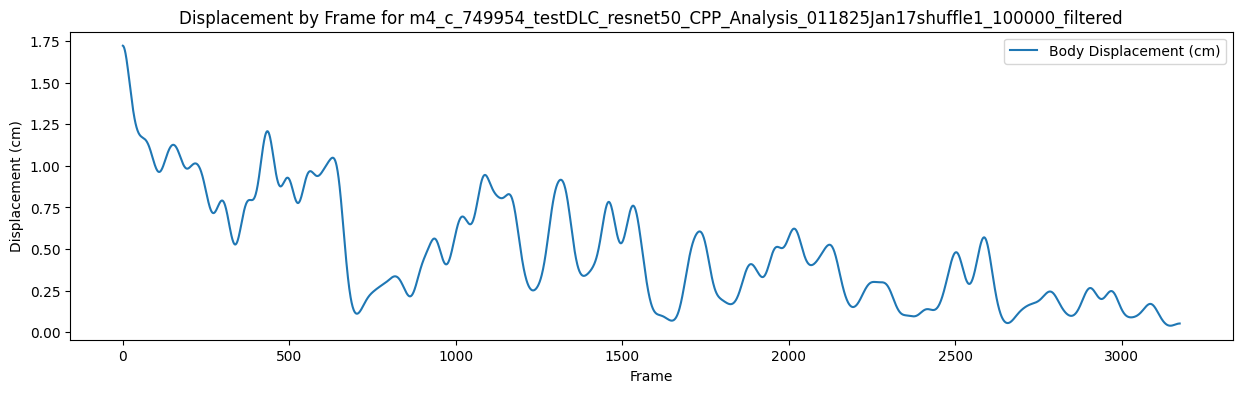

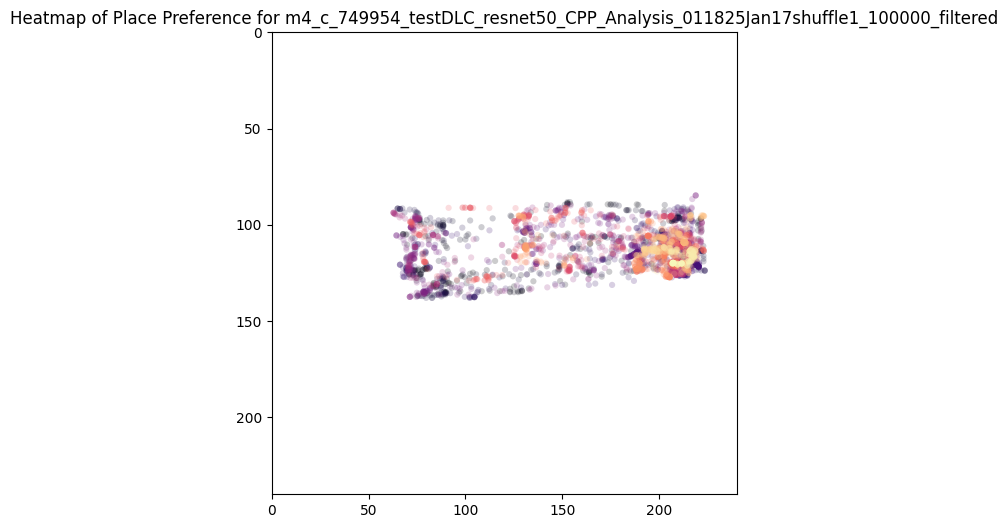

In [6]:
"""
Locomotion by Frame
"""

filePathGraph = '/Users/josephlee/Desktop/Filtered Data/Ying DLC Output/m4_c_749954_testDLC_resnet50_CPP_Analysis_011825Jan17shuffle1_100000_filtered.csv'

# Extracting the trial title from the path name
file_title = os.path.basename(filePathGraph).split('.')[0]

columns= ['frame', 'head_x', 'head_y', 'head_likelihood', 'body_x','body_y','body_likelihood',
                      'left_top_x', 'left_top_y', 'left_top_likelihood',
                      'left_bottom_x', 'left_bottom_y', 'left_bottom_likelihood',
                      'border_top_x','border_top_y','border_top_likelihood', 'border_bottom_x','border_bottom_y','border_bottom_likelihood', 'right_top_x','right_top_y','right_top_likelihood', 'right_bottom_x','right_bottom_y','right_bottom_likelihood']
df_graph = pd.read_csv(filePathGraph, skiprows=3, names=columns, encoding='utf-8')  # Replace with your specific CSV reading logic
        
df_graph = df_graph.drop(columns=['frame','head_x','head_y','head_likelihood','left_bottom_x', 'left_bottom_y','left_bottom_likelihood', 'right_bottom_x','right_bottom_y','right_bottom_likelihood', 'right_top_x','right_top_y','right_top_likelihood'])

df_graph = df_graph.head(3176) # 6 min

#Calling the calculate_locomotion function
locomotion = calculate_locomotion(df_graph)

#This graph will show the movement of the subject mouse by frame  during the test
length_frames = np.arange(len(df_graph)-1)
#time_seconds = np.arange(len(df_graph)-1) / fps

# Plotting a displacement by frame graph to visualize movement by a frame by frame 
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(length_frames, gaussian_filter1d(locomotion['displacement_per_frame'], sigma=20), label='Body Displacement (cm)')
ax.set_xlabel('Frame')
ax.set_ylabel('Displacement (cm)')
ax.set_title('Displacement by Frame' + ' for ' + file_title)
ax.legend()
plt.show()

# Plotting a heatmap to visualize the of overall movement of the mouse during the test)
colors = np.linspace(0, 1, len(df_graph))
plt.figure(figsize=(6,6))
plt.scatter(df_graph['body_x'], df_graph['body_y'], c=colors, cmap='magma', alpha=0.2, linewidths=0, s=20)
plt.xlim(0,240)
plt.ylim(0,240)
plt.title('Heatmap of Place Preference' + ' for ' + file_title)
plt.gca().invert_yaxis()
plt.show()
